#Import

In [104]:
!pip install jmetalpy

In [105]:
import math
import random
import re
import json
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import threading
from threading import Thread

import jmetal


# single objective problem
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm

#operator
from jmetal.operator.mutation import PermutationSwapMutation,PolynomialMutation
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator import BinaryTournamentSelection, BestSolutionSelection

# util
from jmetal.util.comparator import MultiComparator
from jmetal.util.ranking import StrengthRanking
from jmetal.util.density_estimator import KNearestNeighborDensityEstimator
from jmetal.util import termination_criterion
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.termination_criterion import StoppingByEvaluations

#core
from jmetal.core.quality_indicator import *
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution, Solution

#lab
from jmetal.lab.experiment import Experiment, Job, generate_summary_from_experiment



#Read Files

In [106]:
def read_tsplib_file(filename):
    if filename is None:
        raise FileNotFoundError('Filename can not be None')
    with open(filename) as file:
        lines = file.readlines()
        data = [line.lstrip() for line in lines if line != ""]
        dimension = re.compile(r'[^\d]+')
        for item in data:
            if item.startswith('DIMENSION'):
                dimension = int(dimension.sub('', item))
                break
        c = [-1.0] * (2 * dimension)
        cities_coord = []
        for item in data:
            if item[0].isdigit():
                j, coordX, coordY = [float(x.strip()) for x in item.split(' ')]
                c[2 * (int(j) - 1)] = coordX
                c[2 * (int(j) - 1) + 1] = coordY
                cities_coord.append([coordX,coordY])
        cities = pd.DataFrame(cities_coord)
        matrix = [[-1] * dimension for _ in range(dimension)]
        for k in range(dimension):
            matrix[k][k] = 0
            for j in range(k + 1, dimension):
                dist = math.sqrt((c[k * 2] - c[j * 2]) ** 2 + (c[k * 2 + 1] - c[j * 2 + 1]) ** 2)
                dist = round(dist)
                matrix[k][j] = dist
                matrix[j][k] = dist
        return matrix, dimension, cities

#TSP

In [107]:
class myTSP(PermutationProblem):
    def __init__(self, distance_matrix, number_of_cities, fitness_log):
        super(myTSP, self).__init__()
        self.distance_matrix = distance_matrix
        self.number_of_variables = number_of_cities
        self.obj_directions = [self.MINIMIZE]
        self.number_of_objectives = 1
        self.number_of_constraints = 0
        self.fitness_log = fitness_log
        
    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        fitness = 0
        for i in range(self.number_of_variables - 1):
            x = solution.variables[i]
            y = solution.variables[i + 1]
            fitness += self.distance_matrix[x][y]
        first_city, last_city = solution.variables[0], solution.variables[-1]
        fitness += self.distance_matrix[first_city][last_city]
        solution.objectives[0] = fitness
        self.fitness_log.append(fitness)
        return solution
    
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,
                                           number_of_objectives=self.number_of_objectives)
        new_solution.variables = random.sample(range(self.number_of_variables), k=self.number_of_variables)
        return new_solution

    @property
    def number_of_cities(self):
        return self.number_of_variables

    def get_name(self):
        return 'Symmetric TSP'

#Problem

In [108]:
class problem():
  def __init__(self):
        self.problem_name = 'Djibouti 38 TSP'
        self.optimal_fitness = 6656
        self.location = "/dj38.tsp"
        self.dist_matrix, self.nb_cities, self.cities_coord = read_tsplib_file(self.location)

  def myProblem(self, fitness_log): 
    return myTSP(self.dist_matrix, self.nb_cities, fitness_log)

  def getProblemName(self):
    return self.problem_name

  def getOptimalFitness(self):
    return self.optimal_fitness
  
  def getCityCoord(self):
    return self.cities_coord

# n F

#Save To File

In [109]:
class outputFile():
  def __init__(self, my_algo, pop_evolved, log, params, i, maxevals):
    self.algorithm_name = my_algo.get_name()
    self.solution_x = pop_evolved.variables
    self.fitness = pop_evolved.objectives[0]
    self.n_evals = my_algo.evaluations
    self.duration = my_algo.total_computing_time
    self.lensolution = self.solution_x
    self.params = params
    self.i = i
    self.maxevals = maxevals
    self.d = {}

  def create_output_file(self):
    x = problem()

    self.d['Function'] = x.getProblemName()
    self.d['Problem dimension'] = self.lensolution
    self.d['Global Optimum'] = x.getOptimalFitness()
    self.d['Algorithm'] = self.algorithm_name
    self.d['Parameters'] = self.params
    self.d['Fitness'] = self.fitness
    self.d['Solution'] = self.solution_x
    self.d['Nb of functions evaluations'] = self.n_evals
    self.d['Computational time in seconds'] = self.duration
    self.d['Stopping criterion in evaluations'] = self.maxevals

    self.calltosave()

  def calltosave(self):
    try:
      self.x = problem()
      filename = "output"
      filename2 = self.x.getProblemName()
      self.path = os.path.join(filename, filename2)
      Path(self.path).mkdir(parents=True, exist_ok=True)     
    except:
      pass

    try:
      runs_output = "runs_output"
      with open("%s/%s_TSP.txt" %(self.path, self.i), 'w', encoding='utf-8') as f:
        f.write(""+self.i+"° run output:\n")
        json.dump(self.d, f, indent=4, separators=(',',': '))
    except Exception as e:
      print(e)

    f.close()
  
  def outputFitness(self, fitness):
    fun_output = "fun_output"
    try:
      with open("%s/fitnessOutput.FUN" %(self.path), 'w', encoding='utf-8') as f:
        f.write('\n'.join(str(line) for line in fitness))
      f.close()
    except Exception as e:
      print(e)

  def getFitness(self):
    return self.fitness
  
  def outputAllFitness(self, output_result, i):
    var_output = "var_output"
    try:
      try:
        if i == 0:
          # Clean the file 
          with open("%s/routeOutput.VAR" %(self.path), 'w', encoding='utf-8') as f:
            f.close()
      except:
        pass
      # Rewrite non deleting written text
      with open("%s/routeOutput.VAR" %(self.path), 'a', encoding='utf-8') as f:
        f.write(str(output_result))
        f.write('\n')
      f.close()  
    except Exception as e:
      print(e)


#Output

In [110]:
#Last Element Output
class lastOutput():
  def __init__(self, fitness_log, result):
        self.fitness_log = fitness_log
        self.result = result

  # print graph
  def plotMap(self):
    plt.plot(self.fitness_log[::1000])
    plt.xlabel("evaluations (x1000)")
    plt.ylabel("fitness")
    plt.show()

  # print map
  def printMap(self):
    cities_coord = problem().getCityCoord()
    xlist = [cities_coord.iloc[i,0] for i in self.result.variables]
    ylist = [cities_coord.iloc[i,1] for i in self.result.variables]

    xlist.append(xlist[0])
    ylist.append(ylist[0])

    plt.figure(figsize=(16,8))
    for idx,city in enumerate(cities_coord.values):
      plt.scatter(city[0],city[1])
      plt.text(city[0]-20, city[1]+40, str(idx), fontsize=10)

    plt.plot(xlist, ylist, linestyle='-')
    plt.plot(xlist, ylist, linestyle='-')
    plt.axis('scaled')
    plt.show()

  #run all functions
  def getResults(self):
        if __name__ == '__main__':
            self.plotMap()
            self.printMap()

#Problem Execution

In [111]:
class Main():
  def __init__(self, maxevals, popsize, offspring, mut_prob, cross_prob, runs):
    self.maxevals = maxevals
    self.popsize = popsize
    self.offspring = offspring
    self.mut_prob = mut_prob
    self.cross_prob = cross_prob
    self.run = runs
    self.fitness_log = []
    self.fitness = []
    self.output_result = []

  def start(self):
    for self.i in range(self.run):
      print(f"\nrun {self.i+1}")
      self.execute()

    self.output()
    self.x.outputFitness(self.fitness)
    
  def execute(self):
    # Selection
    select = BinaryTournamentSelection(
	  		  		MultiComparator([StrengthRanking.get_comparator(),
		  		  					 KNearestNeighborDensityEstimator.get_comparator()]
			  	  				   ))

    # Termination criteria
    termin = termination_criterion.StoppingByEvaluations(max_evaluations=maxevals)

    # AG algorithm
    algorithm = GeneticAlgorithm(
      problem=problem().myProblem(self.fitness_log),
      population_size=popsize,
      offspring_population_size=offspring,
      mutation=PermutationSwapMutation(mut_prob), 
      crossover=PMXCrossover(cross_prob),
      selection=select,
      termination_criterion=termin,
    )

    params = {
              'population': popsize, 
  	          'offspring': offspring, 
	            'mutation probability': mut_prob, 
		          'crossover probability': cross_prob,
  		  }

    # Call GeneticAlgorithm and execute it #
    algorithm.observable.register(ProgressBarObserver(max=maxevals))
    algorithm.run()

    self.result = algorithm.get_result()
    self.output_result = self.result
    
    self.x = outputFile(algorithm, self.result, self.fitness_log, params, str(self.i+1), self.maxevals)
    
    self.x.create_output_file()
    self.fitness.append(self.x.getFitness())
    self.x.outputAllFitness(self.output_result, self.i)

  def output(self):    
    call = lastOutput(self.fitness_log, self.result)#.getResults()
    call.plotMap()
    call.printMap()
                                                                                

#RUN

Progress: 200200it [00:36, 5431.69it/s]



run 2


Progress: 200200it [00:35, 5589.94it/s]



run 3


Progress: 200200it [00:36, 5516.08it/s]                            


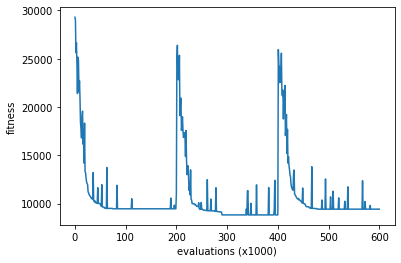

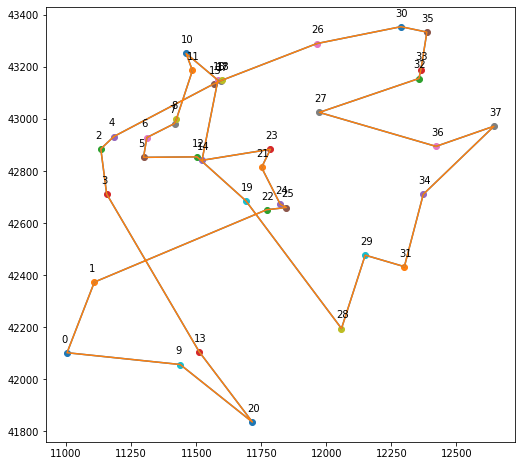

In [114]:
if __name__ == '__main__':
  #params
  maxevals = 200000
  popsize = 440
  offspring = 440
  mut_prob = 0.08
  cross_prob = 0.77

  #call function
  execute = Main(maxevals, popsize, offspring, mut_prob, cross_prob, runs = 3).start()
  
